In [72]:

import sys
sys.path.append('/Users/bence/code/liouvillian_metro/')

import numpy as np
import qutip as qt
import matplotlib.pyplot as plt
from scipy.linalg import expm
import pickle
from copy import deepcopy
from qiskit.quantum_info import DensityMatrix, Statevector, partial_trace, state_fidelity

from oft import oft
from tools.classical import find_ideal_heisenberg, trotter_step_heisenberg_qt, ham_evol_qt

np.random.seed(667)

In [73]:
num_qubits = 3
num_energy_bits = 6
delta = 1
eps = 0.1
sigma = 5
bohr_bound = 2 ** (-num_energy_bits + 1)
beta = 1
eig_index = 2
mix_time = 1.5

hamiltonian = find_ideal_heisenberg(num_qubits, bohr_bound, eps, signed=False, for_oft=True)

initial_state = hamiltonian.eigenstates[:, eig_index]
initial_dm = DensityMatrix(initial_state).data

Original spectrum:  [-3.7    -3.177  -2.5482 -1.7     1.625   2.4547  3.2521  3.7936]
Ideal spectrum:  [0.     0.0314 0.0692 0.1201 0.3198 0.3696 0.4175 0.45  ]
Nonrescaled coefficients:  [1.  0.8 0.9 1. ]
Rescaled coefficients:  [0.06005156 0.04804125 0.05404641 0.06005156]


In [74]:
# Create Gibbs state from eigenstates and eigenenergies
gibbs = expm(-beta * hamiltonian.qt.full()) / np.trace(expm(-beta * hamiltonian.qt.full()))
print(gibbs.shape)

(8, 8)


In [75]:
# Liouvillian, could be from (1.8), i.e. integral over the energies

N = 2**num_energy_bits
N_labels = np.arange(N / 2, dtype=int)
N_labels_neg = np.arange(- N / 2, 0, dtype=int)
N_labels = np.concatenate((N_labels, N_labels_neg))
energy_labels = 2 * np.pi * N_labels / N 
time_labels = N_labels

# rand_jump_index = np.random.randint(0, num_qubits)
site_list = [qt.qeye(2), qt.qeye(2), qt.qeye(2)]
x_jump_ops = []
for q in range(num_qubits):
    site_list[q] = qt.sigmax()
    x_jump_ops.append(qt.tensor(site_list).full())

# boltzmann = lambda beta, energy: np.min([1, np.exp(-beta * energy)])
#?How do I get Liouvillian without a reference DM?

# liouvillian = np.zeros((2**num_qubits, 2**num_qubits), dtype=complex)
# for phase in N_labels:
#     energy = 2 * np.pi * phase / 2**num_energy_bits
#     oft_op = oft(jump_op, phase, 2**num_energy_bits, sigma, hamiltonian=hamiltonian.qt.full())
#     liouvillian += boltzmann(beta, energy)*(-0.5 * oft_op.conj().T @ oft_op @ initial_dm
#                                       -0.5 * initial_dm @ oft_op.conj().T @ oft_op
#                                       + oft_op @ initial_dm @ oft_op.conj().T)
    
    
#TODO: Make this form work
# liouvillian_superop = np.zeros((N**2, N**2), dtype=complex)
# for phase in N_labels:
#     energy = 2 * np.pi * phase / 2**num_energy_bits
#     oft_op = qt.Qobj(np.sqrt(boltzmann(beta, energy)) * oft(jump_op, phase, N, sigma, hamiltonian=hamiltonian.qt.full()))
#     liouvillian_superop = qt.sprepost(oft_op, oft_op.dag()) - 0.5 * qt.sprepost(oft_op.dag() * oft_op, qt.qeye(N)) \
#         - 0.5 * qt.sprepost(qt.qeye(N), oft_op.dag() * oft_op)



### With Qutip MESOLVE

In [76]:
def trdist_to_gibbs(t, state):
    gibbs = qt.Qobj(expm(-beta * hamiltonian.qt.full()) / np.trace(expm(-beta * hamiltonian.qt.full())))
    trdist = qt.tracedist(state, gibbs)
    # print(f'Trace distance to Gibbs at time {t} is {trdist}')
    return trdist

def fid_with_gibbs(t, state):
    gibbs = qt.Qobj(expm(-beta * hamiltonian.qt.full()) / np.trace(expm(-beta * hamiltonian.qt.full())))
    fid = qt.fidelity(state, gibbs)
    # print(f'Fidelity with Gibbs at time {t} is {fid}')
    return fid

all_oft_jump_ops = []
for i in range(len(x_jump_ops)):
    jump_op = x_jump_ops[i]
    for phase in N_labels:
        energy = 2 * np.pi * phase / 2**num_energy_bits
        oft_op = oft(jump_op, phase, 2**num_energy_bits, sigma, hamiltonian=hamiltonian.qt.full())
        all_oft_jump_ops.append(qt.Qobj(oft_op))

no_H = qt.qeye(2**num_qubits)
times = np.linspace(0.0, mix_time, 10)
result_qt = qt.mesolve(no_H, qt.Qobj(initial_dm), times, all_oft_jump_ops, 
                       e_ops=[trdist_to_gibbs, fid_with_gibbs], options=qt.Options(store_states=True))


In [77]:
print(f'Last fid value is {result_qt.expect[1][-1]}')

Last fid value is (0.9938266994026423+0j)


/Users/bence/miniforge3/envs/qiskit_env/lib/python3.11/site-packages/matplotlib/cbook.py:1699: ComplexWarning: Casting complex values to real discards the imaginary part
  return math.isfinite(val)
/Users/bence/miniforge3/envs/qiskit_env/lib/python3.11/site-packages/matplotlib/cbook.py:1345: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)


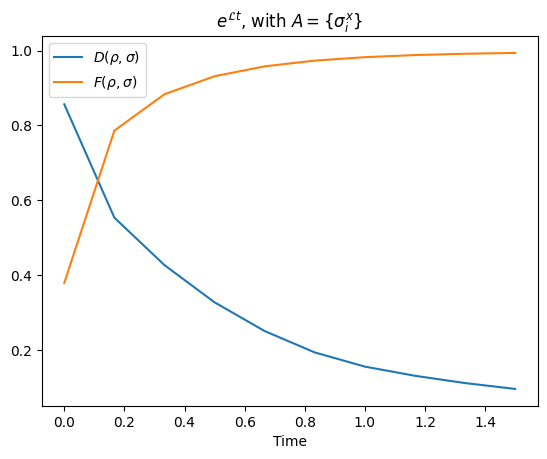

In [78]:
plt.figure() 
plt.title('$e^{\mathcal{L}t}$, with $A = \{\sigma_i^x\}$')
plt.plot(times, result_qt.expect[0]) 
plt.plot(times, result_qt.expect[1]) 
plt.xlabel('Time') 
plt.legend(("$D(\\rho, \sigma)$", "$F(\\rho, \sigma)$")) 
plt.show() 

### $\left[ \mathbb{I} + \mathcal{L}\delta + \mathcal{O}(\delta^2) \right] \times \lceil t_{mix} / \delta \rceil$

In [79]:
def alg_liouv_evolve(initial_dm: np.ndarray, time: float, delta: float, jump_ops: list[np.ndarray]) -> np.ndarray:
    """
    time evolution is between [0, time]
    `jump_ops`: non-OFT form
    """
    
    num_liouv_steps = int(np.ceil(time / delta))
    
    N = 2**num_energy_bits
    N_labels = np.arange(N / 2, dtype=int)
    N_labels_neg = np.arange(- N / 2, 0, dtype=int)
    N_labels = np.concatenate((N_labels, N_labels_neg))
    
    boltzmann = lambda beta, energy: np.min([1, np.exp(-beta * energy)])
    
    evolved_dms = []
    evolved_dm = deepcopy(initial_dm)
    #* Exact
    for liouv_step in range(num_liouv_steps): #? Normalize?
        print(f'Liouv step {liouv_step}')
        
        rand_jump_index = np.random.randint(0, len(jump_ops))
        jump_op = jump_ops[rand_jump_index]
        print(f'Jump on site {rand_jump_index}')
        
        previous_dm = deepcopy(evolved_dm) / np.trace(evolved_dm)
        for phase in N_labels:
            energy = 2 * np.pi * phase / N
            oft_op = oft(jump_op, phase, N, sigma, hamiltonian=hamiltonian.qt.full())
            evolved_dm += delta * boltzmann(beta, energy)*(-0.5 * oft_op.conj().T @ oft_op @ previous_dm
                                            -0.5 * previous_dm @ oft_op.conj().T @ oft_op
                                            + oft_op @ previous_dm @ oft_op.conj().T)

        evolved_dms.append(evolved_dm / np.trace(evolved_dm))
        
    return evolved_dms

alg_evolved_dms = alg_liouv_evolve(initial_dm, mix_time*3, 1.0, jump_ops=x_jump_ops)


Liouv step 0
Jump on site 1
Liouv step 1
Jump on site 1
Liouv step 2
Jump on site 0
Liouv step 3
Jump on site 2
Liouv step 4
Jump on site 0


In [80]:
# exact_state_at_t = lambda t: result_qt.states[np.argmin(np.abs(times - t))]
#? Why can the fidelity be over 1 in larger delta cases? Is it because it somehow deviates after a while from a CPTP map
#? And for that Fidelity becomes inappropriate, even if we normalize the states?

exact_state = result_qt.states[-1] / np.trace(result_qt.states[-1])

trdist_alg_exact = qt.tracedist(qt.Qobj(alg_evolved_dms[-1]), exact_state)
fid_alg_exact = qt.fidelity(qt.Qobj(alg_evolved_dms[-1]), exact_state)
print(f'Trace distance between exact and alg is {trdist_alg_exact}')
print(f'Fidelity between exact and alg is {fid_alg_exact}')

Trace distance between exact and alg is 0.3151295030530092
Fidelity between exact and alg is 0.932959404568833


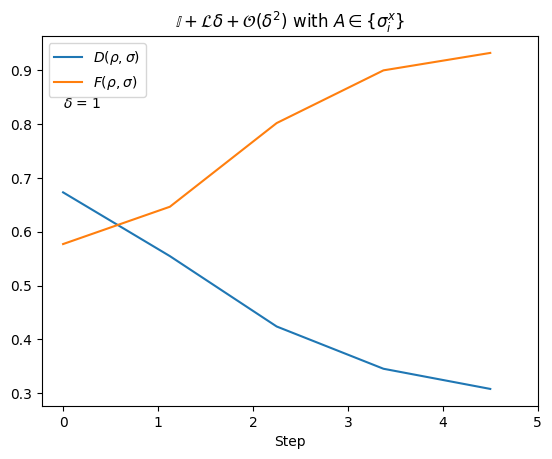

In [81]:
liouv_times = np.linspace(0.0, mix_time*3, len(alg_evolved_dms))
fid_alg_with_gibbs = [qt.fidelity(qt.Qobj(dm), qt.Qobj(gibbs)) for dm in alg_evolved_dms]
trdist_alg_with_gibbs = [qt.tracedist(qt.Qobj(dm), qt.Qobj(gibbs)) for dm in alg_evolved_dms]
plt.figure() 
plt.title('$\mathbb{I} + \mathcal{L}\delta + \mathcal{O}(\delta^2)$ with $A\in\{\sigma_i^x\}$')
plt.plot(liouv_times, trdist_alg_with_gibbs) 
plt.plot(liouv_times, fid_alg_with_gibbs) 
plt.xlabel('Step')
plt.xticks(np.arange(0, mix_time*3 + 1, delta))
plt.legend(("$D(\\rho, \sigma)$", "$F(\\rho, \sigma)$"))
plt.annotate(f'$\delta$ = {delta}', xy=(0, 0.83))
plt.show() 

### From the circuit